# Rhythm Estimation and Evaluation of Bambucos with Source Separation Pre-processing
by:

Jose R. Zapata and Antonio Escamilla

**Project ACMUS:**  https://acmus-mir.github.io/


## Installing libraries and import statements

In [ ]:
!python -m pip install essentia -q
!python -m pip install madmom -q  

     |████████████████████████████████| 12.0MB 7.5MB/s 
     |████████████████████████████████| 20.0MB 1.3MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import madmom
import essentia.standard as es
import madmom.evaluation.beats as be # beat evaluation
plt.rcParams["figure.figsize"] =(12,6)
%load_ext google.colab.data_table

## Get Audiofiles and Annotations

Audio Files and Annotation are in google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Download Audio Files and Annotations from Zenodo:

https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1

In [ ]:
#Download files from Zenodo
!wget -O rhythm_set.zip https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1

--2021-06-16 09:42:05--  https://zenodo.org/record/3965447/files/rhythm_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1843834847 (1.7G) [application/octet-stream]
Saving to: ‘rhythm_set.zip’

rhythm_set.zip      100%[===================>]   1.72G  14.1MB/s    in 2m 2s   

2021-06-16 09:44:08 (14.5 MB/s) - ‘rhythm_set.zip’ saved [1843834847/1843834847]



In [ ]:
# Unzip file
!unzip -q rhythm_set.zip -d ./rhythm_set

In [ ]:
# Directory in GDrive where the separated audio files are saved
audio_Sep_Dir = '/content/gdrive/My Drive/ACMus/Music/Confidence_study/separations/rhythm_set/'

Create folder to copy separated audiofiles

In [ ]:
!mkdir ./rhythm_set/AudioSep

In [ ]:
# Get the list of Audio Files
import glob, os
import shutil

audio_list = glob.glob(audio_Sep_Dir+'*/')

In [ ]:
# Read annotations file ('file name' and 'presence of bass' columns)
bass_annot = pd.read_excel('/content/gdrive/MyDrive/ACMus/Music/DataSet/Rhythm set/rhythm_set.xlsx', usecols=['File name', 'Presence of bass'])

In [ ]:
# Read corresponding separated bass if the 'presence of bass' annotation is 1 
bass_annot = bass_annot[bass_annot['Presence of bass'] != 0]
for f_name in bass_annot['File name']:
  folder_name = f_name.split('.')[0]
  shutil.copy(audio_Sep_Dir + folder_name + '/bass.wav', './rhythm_set/AudioSep/'+f_name)

## Set Bambucos Data

In [ ]:
audioDirectory = './rhythm_set/AudioSep/'                   # Audio files
anotationDirectory='./rhythm_set/Beat_annotations/'         # Anotation files

In [ ]:
bambuco_set = pd.DataFrame(columns=['audiofile','simple_ann','compound_ann'])

In [ ]:
# Read annotations file and filter according to the 'presence of bass' column
rhythm_set =  pd.read_excel('/content/gdrive/MyDrive/ACMus/Music/DataSet/Rhythm set/rhythm_set.xlsx')
rhythm_set = rhythm_set[rhythm_set['Presence of bass'] != 0]
rhythm_set.head()

,File name,Title,Genre,Composer,Time signature,Presence of bass,Kind of bass,Meter tag,Collection,Date,Original file,Obs,Sampling rate,Bits,Duration,Channels,Madmon Obs,Essentia Obs,BPM(0),BPM(1),Mono,Channel correlation
11,rh_0012.wav,Centauro,pasaje,José Luis Martínez,3/4,1.0,Acoustic,0,LUB,NaN,"Cassete01, lado B, 06 Centauro (pasaje).wav",NaN,96000,24,28.63,2,NaN,NaN,244,0,0,0.941
18,rh_0019.wav,El maestro Nicanor,pasillo,Oriol Rangel,3/4,1.0,Acoustic,0,LUB,NaN,"Cassete005, lado A, 02 Vida y obra de Oriol Ra...",NaN,96000,24,14.91,2,NaN,NaN,135,0,0,0.102
19,rh_0020.wav,Mi caballo pillo,joropo,Oriol Rangel,3/4,1.0,Acoustic,0,LUB,NaN,"Cassete005, lado A, 02 Vida y obra de Oriol Ra...",NaN,96000,24,25.88,2,NaN,NaN,225,0,0,-0.017
20,rh_0021.wav,Sentimiento campesino,pasillo,Oriol Rangel,3/4,1.0,Electric,0,LUB,NaN,"Cassete005, lado A, 02 Vida y obra de Oriol Ra...",NaN,96000,24,16.98,2,NaN,NaN,173,0,0,0.808
21,rh_0022.wav,Lucía y Helena,bambuco,Oriol Rangel,6/8,1.0,Electric,1,LUB,NaN,"Cassete005, lado B, 02 Vida y obra de Oriol Ra...",NaN,96000,24,19.98,2,NaN,NaN,194,130,0,0.749


In [ ]:
# Filter again to use only audio samples annotated as bambuco genre
bambuco_set['audiofile'] = rhythm_set[rhythm_set['Genre']=='bambuco']['File name'].str.strip()
bambuco_set.reset_index(drop=True, inplace = True)
print(f'Number of Bambuco Files with Bass instrument= {len(bambuco_set)}')

Number of Bambuco Files with Bass instrument= 36


In [ ]:
# use sample name to complete the file name for simple and compound annotations
bambuco_set['simple_ann'] = bambuco_set['audiofile'].str.split('.').apply(lambda x: x[0])+'(0).txt'
bambuco_set['compound_ann'] = bambuco_set['audiofile'].str.split('.').apply(lambda x: x[0])+'(1).txt'
bambuco_set.head()

,audiofile,simple_ann,compound_ann
0,rh_0022.wav,rh_0022(0).txt,rh_0022(1).txt
1,rh_0025.wav,rh_0025(0).txt,rh_0025(1).txt
2,rh_0036.wav,rh_0036(0).txt,rh_0036(1).txt
3,rh_0038.wav,rh_0038(0).txt,rh_0038(1).txt
4,rh_0039.wav,rh_0039(0).txt,rh_0039(1).txt


## Get Ground Truth

In [ ]:
def read_ann(file):
  '''
  function to read .txt annotations file
  returns numpy array
  '''
  beatsItt = list()
  
  with open(os.path.join(anotationDirectory, file), 'r') as f:
    lines= [line.split() for line in f]
    for line in lines:
      beatsItt.append(np.float32(line[0]))
    beatsItt=np.asarray(beatsItt)
    return beatsItt

In [ ]:
# read annotations in txt files and fill the data frame with it
bambuco_set['simple_gt'] = bambuco_set['simple_ann'].apply(read_ann)
bambuco_set['compound_gt'] = bambuco_set['compound_ann'].apply(read_ann)

## Estimate Beats



### Madmom Beat Estimation

In [ ]:
# DownBeat = DB_
Rhythm_madmom = pd.DataFrame(columns=['File_name','Madmom_Beats'])

# Madmom
proc_beats = madmom.features.beats.BeatTrackingProcessor(fps=100)

for num, file in bambuco_set.iterrows():
  # Madmom Tempo estimation
  act = madmom.features.beats.RNNBeatProcessor()(audioDirectory+file['audiofile'])
  # Madmom Beat estimation
  beatsMadmom = np.float32(proc_beats(act))

  Rhythm_madmom.loc[len(Rhythm_madmom)] = [file['audiofile'], beatsMadmom]

### Essentia Beat estimation

In [ ]:
Rhythm_ess = pd.DataFrame(columns=['File_name', 'Essentia_Beats', 'Essentia_Bpm', 'Confidence'])
# Essentia
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")

for num, file in bambuco_set.iterrows():
  rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
    
  # Essentia estimations 
  audio = es.MonoLoader(filename=audioDirectory+file['audiofile'])()
  try:
    bpmEss,beatsEss, beats_confidence, _, _ = rhythm_extractor(audio)
  except:
    bpmEss = 0
    beatsEss = 0
    beats_confidence = 0
  Rhythm_ess.loc[len(Rhythm_ess)] = [file['audiofile'], beatsEss, bpmEss, beats_confidence]
  del audio

# Beat Evaluation


## Simple Meter


### Madmom Evaluation


In [ ]:
# Create a column by evaluation metrics
Rhythm_madmom['fmeasure']=''
Rhythm_madmom['amlc']=''
Rhythm_madmom['amlt']=''
Rhythm_madmom['cmlc']=''
Rhythm_madmom['cmlt']=''
Rhythm_madmom['Eval'] =''

In [ ]:
for n, file in bambuco_set.iterrows():
  Rhythm_madmom['Eval'][n] = be.BeatEvaluation(Rhythm_madmom['Madmom_Beats'][n], file['simple_gt']) # run madmom evaluation using simple meter ground truth
  Rhythm_madmom['fmeasure'][n]= Rhythm_madmom['Eval'][n].fmeasure*100                               # fill in all evaluation metrics
  Rhythm_madmom['amlc'][n]= Rhythm_madmom['Eval'][n].amlc*100
  Rhythm_madmom['amlt'][n]= Rhythm_madmom['Eval'][n].amlt*100
  Rhythm_madmom['cmlc'][n]= Rhythm_madmom['Eval'][n].cmlc*100
  Rhythm_madmom['cmlt'][n]= Rhythm_madmom['Eval'][n].cmlt*100

In [ ]:
Rhythm_madmom[['fmeasure','amlc', 'amlt', 'cmlc', 'cmlt']] = Rhythm_madmom[['fmeasure', 'amlc', 'amlt', 'cmlc', 'cmlt']].apply(pd.to_numeric)

#### Madmom Evaluation Results


In [ ]:
# Filter the bambuco set if the beat tracking is poor
# use the Fscore below 40% as criteria for filtering the bambuco set
poor_separation_filenames = Rhythm_madmom.File_name[Rhythm_madmom.fmeasure < 40].values.tolist()

# we will call this, the 'refined bambuco set'
refined_bambuco_set = bambuco_set[~bambuco_set.audiofile.isin(poor_separation_filenames)]
refined_bambuco_set.reset_index(drop=True, inplace = True)

In [ ]:
%unload_ext google.colab.data_table
# use the above criteria to visualize evaluation results from Madmom
Rhythm_madmom = Rhythm_madmom[~Rhythm_madmom.File_name.isin(poor_separation_filenames)]
Rhythm_madmom.reset_index(drop=True, inplace = True)
colu = ['fmeasure', 'amlc', 'amlt', 'cmlc', 'cmlt']
display(Rhythm_madmom[colu])

The google.colab.data_table extension is not loaded.


,fmeasure,amlc,amlt,cmlc,cmlt
0,62.365591,50.000000,50.000000,19.672131,21.311475
1,69.064748,37.500000,41.071429,10.843373,22.891566
2,97.872340,95.833333,95.833333,95.833333,95.833333
3,97.872340,93.750000,93.750000,93.750000,93.750000
4,79.310345,70.000000,73.333333,70.000000,73.333333
5,83.636364,80.000000,80.000000,80.000000,80.000000
6,97.142857,94.444444,94.444444,94.444444,94.444444
7,96.703297,95.652174,95.652174,95.652174,95.652174
8,96.296296,96.296296,96.296296,96.296296,96.296296
9,84.745763,80.000000,90.000000,80.000000,90.000000


In [ ]:
Rhythm_madmom[colu].describe()

,fmeasure,amlc,amlt,cmlc,cmlt
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,81.065643,63.578049,73.508408,57.336144,67.615334
std,18.629544,31.163716,26.740233,35.491188,33.015839
min,40.425532,14.893617,17.021277,0.000000,0.000000
25%,66.666667,33.333333,54.545455,21.739130,33.333333
50%,84.782609,70.000000,85.416667,62.500000,82.692308
75%,97.142857,95.652174,95.652174,95.652174,95.652174
max,100.000000,100.000000,100.000000,100.000000,100.000000


In [ ]:
pd.DataFrame(Rhythm_madmom[colu].mean().T)

,0
fmeasure,81.065643
amlc,63.578049
amlt,73.508408
cmlc,57.336144
cmlt,67.615334


#### Madmom Evaluation Boxplot


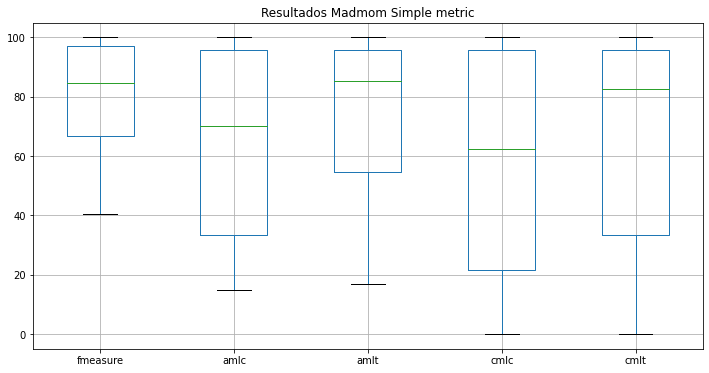

In [ ]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_madmom[colu].boxplot()
plt.title('Resultados Madmom Simple metric');

### Essentia Evaluation

In [ ]:
# Create a column by evaluation metrics
Rhythm_ess['fmeasure']=''
Rhythm_ess['amlc']=''
Rhythm_ess['amlt']=''
Rhythm_ess['cmlc']=''
Rhythm_ess['cmlt']=''
Rhythm_ess['Eval'] =''

In [ ]:
for n, file in bambuco_set.iterrows():  
  Rhythm_ess['Eval'][n] = be.BeatEvaluation(Rhythm_ess['Essentia_Beats'][n], file['simple_gt']) # run essentia evaluation using simple meter ground truth
  Rhythm_ess['fmeasure'][n]= Rhythm_ess['Eval'][n].fmeasure*100                                 # fill in all evaluation metrics
  Rhythm_ess['amlc'][n]= Rhythm_ess['Eval'][n].amlc*100
  Rhythm_ess['amlt'][n]= Rhythm_ess['Eval'][n].amlt*100
  Rhythm_ess['cmlc'][n]= Rhythm_ess['Eval'][n].cmlc*100
  Rhythm_ess['cmlt'][n]= Rhythm_ess['Eval'][n].cmlt*100

In [ ]:
Rhythm_ess[colu] = Rhythm_ess[colu].apply(pd.to_numeric)

#### Essentia Evaluation Results


In [ ]:
# use the 'poor separation' criteria again, to visualize evaluation results from Essentia
Rhythm_ess = Rhythm_ess[~Rhythm_ess.File_name.isin(poor_separation_filenames)]
Rhythm_ess.reset_index(drop=True, inplace = True)
display(Rhythm_ess[colu])

,fmeasure,amlc,amlt,cmlc,cmlt
0,41.463415,90.476190,90.476190,0.000000,0.000000
1,43.548387,45.238095,71.428571,0.000000,0.000000
2,31.578947,6.666667,6.666667,0.000000,0.000000
3,83.870968,36.170213,80.851064,36.170213,80.851064
4,71.428571,67.857143,67.857143,67.857143,67.857143
5,71.698113,35.714286,67.857143,35.714286,67.857143
6,98.550725,97.142857,97.142857,97.142857,97.142857
7,96.629213,91.111111,95.555556,91.111111,95.555556
8,92.592593,92.592593,92.592593,92.592593,92.592593
9,84.745763,80.000000,93.333333,80.000000,93.333333


In [ ]:
Rhythm_ess[colu].describe()

,fmeasure,amlc,amlt,cmlc,cmlt
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,60.652344,44.272093,53.522086,32.592034,40.525114
std,25.796992,36.452026,39.585212,38.492336,43.596198
min,25.396825,0.000000,0.000000,0.000000,0.000000
25%,37.037037,3.703704,3.703704,0.000000,0.000000
50%,56.250000,40.909091,67.857143,0.000000,0.000000
75%,84.745763,80.000000,90.476190,67.857143,88.461538
max,98.989899,98.000000,98.000000,98.000000,98.000000


In [ ]:
pd.DataFrame(Rhythm_ess[colu].mean().T)

,0
fmeasure,60.652344
amlc,44.272093
amlt,53.522086
cmlc,32.592034
cmlt,40.525114


#### Essentia Evaluation Boxplot


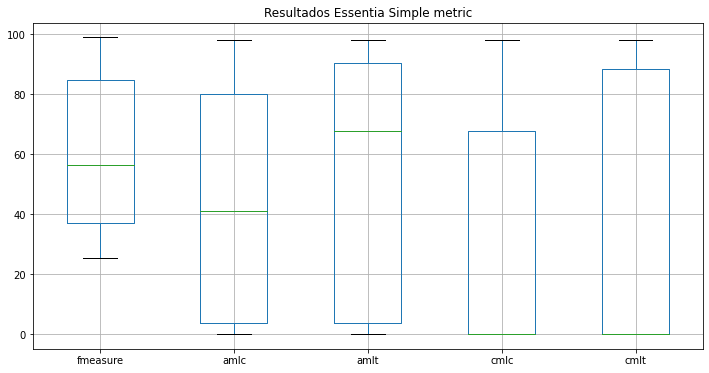

In [ ]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_ess[colu].boxplot()
plt.title('Resultados Essentia Simple metric');

## Compound Meter

### Madmom Evaluation


In [ ]:
# Create a column by evaluation metrics
Rhythm_madmom['fmeasure_comp']=''
Rhythm_madmom['amlc_comp']=''
Rhythm_madmom['amlt_comp']=''
Rhythm_madmom['cmlc_comp']=''
Rhythm_madmom['cmlt_comp']=''
Rhythm_madmom['Eval_comp'] =''

In [ ]:
# this time use only 'refined bambuco set' to run madmom evaluation
for n, file in refined_bambuco_set.iterrows():  
  Rhythm_madmom['Eval_comp'][n] = be.BeatEvaluation(Rhythm_madmom['Madmom_Beats'][n], file['compound_gt'])  # run madmom evaluation using compound meter ground truth
  Rhythm_madmom['fmeasure_comp'][n]= Rhythm_madmom['Eval_comp'][n].fmeasure*100                             # fill in all evaluation metrics
  Rhythm_madmom['amlc_comp'][n]= Rhythm_madmom['Eval_comp'][n].amlc*100
  Rhythm_madmom['amlt_comp'][n]= Rhythm_madmom['Eval_comp'][n].amlt*100
  Rhythm_madmom['cmlc_comp'][n]= Rhythm_madmom['Eval_comp'][n].cmlc*100
  Rhythm_madmom['cmlt_comp'][n]= Rhythm_madmom['Eval_comp'][n].cmlt*100

In [ ]:
colu2 = ['fmeasure_comp', 'amlc_comp', 'amlt_comp', 'cmlc_comp', 'cmlt_comp']
Rhythm_madmom[colu2] = Rhythm_madmom[colu2].apply(pd.to_numeric)

#### Madmom Evaluation Results


In [ ]:
Rhythm_madmom[colu2].describe()

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,39.880859,12.081023,13.400431,6.538298,7.472853
std,17.082794,26.992293,27.669960,21.546168,22.495672
min,13.698630,0.000000,0.000000,0.000000,0.000000
25%,32.142857,0.000000,0.000000,0.000000,0.000000
50%,36.363636,0.000000,0.000000,0.000000,0.000000
75%,40.000000,5.128205,5.128205,0.000000,0.000000
max,100.000000,97.560976,97.560976,97.560976,97.560976


In [ ]:
pd.DataFrame(Rhythm_madmom[colu2].mean()).T

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
0,39.880859,12.081023,13.400431,6.538298,7.472853


#### Madmom Evaluation Boxplot


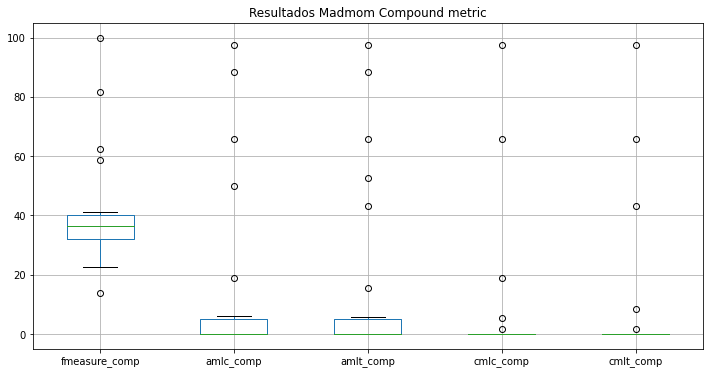

In [ ]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_madmom[colu2].boxplot()
plt.title('Resultados Madmom Compound metric');

### Essentia Evaluation

In [ ]:
# Create a column by evaluation metrics
Rhythm_ess['fmeasure_comp']=''
Rhythm_ess['amlc_comp']=''
Rhythm_ess['amlt_comp']=''
Rhythm_ess['cmlc_comp']=''
Rhythm_ess['cmlt_comp']=''
Rhythm_ess['Eval_comp'] =''

In [ ]:
# again, use only 'refined bambuco set' to run Essentia evaluation
for n, file in refined_bambuco_set.iterrows():  
  Rhythm_ess['Eval_comp'][n] = be.BeatEvaluation(Rhythm_ess['Essentia_Beats'][n], file['compound_gt'])
  Rhythm_ess['fmeasure_comp'][n]= Rhythm_ess['Eval_comp'][n].fmeasure*100
  Rhythm_ess['amlc_comp'][n]= Rhythm_ess['Eval_comp'][n].amlc*100
  Rhythm_ess['amlt_comp'][n]= Rhythm_ess['Eval_comp'][n].amlt*100
  Rhythm_ess['cmlc_comp'][n]= Rhythm_ess['Eval_comp'][n].cmlc*100
  Rhythm_ess['cmlt_comp'][n]= Rhythm_ess['Eval_comp'][n].cmlt*100

In [ ]:
Rhythm_ess[colu2] = Rhythm_ess[colu2].apply(pd.to_numeric)

#### Essentia Evaluation Results


In [ ]:
Rhythm_ess[colu2].describe()

In [ ]:
pd.DataFrame(Rhythm_ess[colu2].mean()).T

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
0,32.07381,19.600581,25.163877,9.768809,11.449843


#### Essentia Evaluation Boxplot


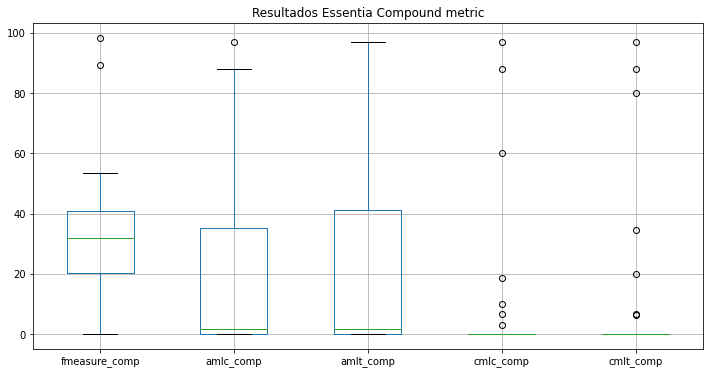

In [ ]:
plt.rcParams["figure.figsize"] =(12,6) 
Rhythm_ess[colu2].boxplot()
plt.title('Resultados Essentia Compound metric');

# Summary of Results 

In [ ]:
simple = pd.concat([Rhythm_madmom[colu].mean(), Rhythm_ess[colu].mean()], axis=1).T
simple['names'] =['Madmom', 'Essentia']
simple.set_index('names',inplace=True)
print('Simple Meter results')
simple.round(2)

Simple Meter results


,fmeasure,amlc,amlt,cmlc,cmlt
names,,,,,
Madmom,81.07,63.58,73.51,57.34,67.62
Essentia,60.65,44.27,53.52,32.59,40.53


In [ ]:
compound = pd.concat([Rhythm_madmom[colu2].mean(), Rhythm_ess[colu2].mean()], axis=1).T
compound['names'] =['Madmom', 'Essentia']
compound.set_index('names',inplace=True)
print('Compound Meter Results')
compound.round(2)

Compound Meter Results


,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
names,,,,,
Madmom,39.88,12.08,13.40,6.54,7.47
Essentia,32.07,19.60,25.16,9.77,11.45


# Rhythm Estimation and Evaluation for previous group of bambucos but without source separation (audio samples from the original mix)

In [ ]:
originalAudioDirectory = './rhythm_set/Audio/' # Audio files

### Beat Estimation Using Madmom

In [ ]:
# DownBeat = DB_
Rhythm_madmom = pd.DataFrame(columns=['File_name','Madmom_Beats'])

# Madmom
proc_beats = madmom.features.beats.BeatTrackingProcessor(fps=100)

for num, file in refined_bambuco_set.iterrows():
  # Madmom Tempo estimation
  act = madmom.features.beats.RNNBeatProcessor()(originalAudioDirectory+file['audiofile'])
  # Madmom Beat estimation
  beatsMadmom = np.float32(proc_beats(act))
  Rhythm_madmom.loc[len(Rhythm_madmom)] = [file['audiofile'], beatsMadmom]

#### Simple Meter Evaluation

In [ ]:
# Create a column by evaluation metrics
Rhythm_madmom['fmeasure']=''
Rhythm_madmom['amlc']=''
Rhythm_madmom['amlt']=''
Rhythm_madmom['cmlc']=''
Rhythm_madmom['cmlt']=''
Rhythm_madmom['Eval'] =''

for n, file in refined_bambuco_set.iterrows():
  Rhythm_madmom['Eval'][n] = be.BeatEvaluation(Rhythm_madmom['Madmom_Beats'][n], file['simple_gt'])
  Rhythm_madmom['fmeasure'][n]= Rhythm_madmom['Eval'][n].fmeasure*100
  Rhythm_madmom['amlc'][n]= Rhythm_madmom['Eval'][n].amlc*100
  Rhythm_madmom['amlt'][n]= Rhythm_madmom['Eval'][n].amlt*100
  Rhythm_madmom['cmlc'][n]= Rhythm_madmom['Eval'][n].cmlc*100
  Rhythm_madmom['cmlt'][n]= Rhythm_madmom['Eval'][n].cmlt*100

colu = ['fmeasure', 'amlc', 'amlt', 'cmlc', 'cmlt']
Rhythm_madmom[colu] = Rhythm_madmom[colu]].apply(pd.to_numeric)

In [ ]:
pd.DataFrame(Rhythm_madmom[colu].mean()).T

,fmeasure,amlc,amlt,cmlc,cmlt
0,89.561873,75.407771,85.343554,70.551134,80.486917


#### Compound Meter Evaluation

In [ ]:
# Create a column by evaluation metrics
Rhythm_madmom['fmeasure_comp']=''
Rhythm_madmom['amlc_comp']=''
Rhythm_madmom['amlt_comp']=''
Rhythm_madmom['cmlc_comp']=''
Rhythm_madmom['cmlt_comp']=''
Rhythm_madmom['Eval_comp'] =''

for n, file in refined_bambuco_set.iterrows():  
  Rhythm_madmom['Eval_comp'][n] = be.BeatEvaluation(Rhythm_madmom['Madmom_Beats'][n], file['compound_gt'])
  Rhythm_madmom['fmeasure_comp'][n]= Rhythm_madmom['Eval_comp'][n].fmeasure*100
  Rhythm_madmom['amlc_comp'][n]= Rhythm_madmom['Eval_comp'][n].amlc*100
  Rhythm_madmom['amlt_comp'][n]= Rhythm_madmom['Eval_comp'][n].amlt*100
  Rhythm_madmom['cmlc_comp'][n]= Rhythm_madmom['Eval_comp'][n].cmlc*100
  Rhythm_madmom['cmlt_comp'][n]= Rhythm_madmom['Eval_comp'][n].cmlt*100

colu2 = ['fmeasure_comp', 'amlc_comp', 'amlt_comp', 'cmlc_comp', 'cmlt_comp']
Rhythm_madmom[colu2] = Rhythm_madmom[colu2].apply(pd.to_numeric)

In [ ]:
pd.DataFrame(Rhythm_madmom[colu2].mean()).T

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
0,44.101533,10.736208,10.790942,9.298499,9.298499


### Beat Estimation Using Essentia

In [ ]:
Rhythm_ess = pd.DataFrame(columns=['File_name', 'Essentia_Beats', 'Essentia_Bpm', 'Confidence'])
# Essentia
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")

for num, file in refined_bambuco_set.iterrows():
  rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
    
  # Essentia estimations 
  audio = es.MonoLoader(filename=originalAudioDirectory+file['audiofile'])()
  try:
    bpmEss,beatsEss, beats_confidence, _, _ = rhythm_extractor(audio)
  except:
    bpmEss = 0
    beatsEss = 0
    beats_confidence = 0
  Rhythm_ess.loc[len(Rhythm_ess)] = [file['audiofile'], beatsEss, bpmEss, beats_confidence]
  del audio

#### Simple Meter Evaluation

In [ ]:
# Create a column by evaluation metrics
Rhythm_ess['fmeasure']=''
Rhythm_ess['amlc']=''
Rhythm_ess['amlt']=''
Rhythm_ess['cmlc']=''
Rhythm_ess['cmlt']=''
Rhythm_ess['Eval'] =''

for n, file in refined_bambuco_set.iterrows():  
  Rhythm_ess['Eval'][n] = be.BeatEvaluation(Rhythm_ess['Essentia_Beats'][n], file['simple_gt'])
  Rhythm_ess['fmeasure'][n]= Rhythm_ess['Eval'][n].fmeasure*100
  Rhythm_ess['amlc'][n]= Rhythm_ess['Eval'][n].amlc*100
  Rhythm_ess['amlt'][n]= Rhythm_ess['Eval'][n].amlt*100
  Rhythm_ess['cmlc'][n]= Rhythm_ess['Eval'][n].cmlc*100
  Rhythm_ess['cmlt'][n]= Rhythm_ess['Eval'][n].cmlt*100

Rhythm_ess[colu] = Rhythm_ess[colu].apply(pd.to_numeric)

In [ ]:
pd.DataFrame(Rhythm_ess[colu].mean()).T

,fmeasure,amlc,amlt,cmlc,cmlt
0,46.999189,24.715216,26.927591,18.603276,20.645196


#### Compound Meter Evaluation

In [ ]:
# Create a column by evaluation metrics
Rhythm_ess['fmeasure_comp']=''
Rhythm_ess['amlc_comp']=''
Rhythm_ess['amlt_comp']=''
Rhythm_ess['cmlc_comp']=''
Rhythm_ess['cmlt_comp']=''
Rhythm_ess['Eval_comp'] =''

for n, file in refined_bambuco_set.iterrows():  
  Rhythm_ess['Eval_comp'][n] = be.BeatEvaluation(Rhythm_ess['Essentia_Beats'][n], file['compound_gt'])
  Rhythm_ess['fmeasure_comp'][n]= Rhythm_ess['Eval_comp'][n].fmeasure*100
  Rhythm_ess['amlc_comp'][n]= Rhythm_ess['Eval_comp'][n].amlc*100
  Rhythm_ess['amlt_comp'][n]= Rhythm_ess['Eval_comp'][n].amlt*100
  Rhythm_ess['cmlc_comp'][n]= Rhythm_ess['Eval_comp'][n].cmlc*100
  Rhythm_ess['cmlt_comp'][n]= Rhythm_ess['Eval_comp'][n].cmlt*100

Rhythm_ess[colu2] = Rhythm_ess[colu2].apply(pd.to_numeric)

In [ ]:
pd.DataFrame(Rhythm_ess[colu2].mean()).T

,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
0,46.584708,45.818478,51.99985,34.261613,36.115062


### Summary of Results

In [ ]:
simple = pd.concat([Rhythm_madmom[colu].mean(), Rhythm_ess[colu].mean()], axis=1).T
simple['names'] =['Madmom', 'Essentia']
simple.set_index('names',inplace=True)
print('Simple Meter results')
simple.round(2)

Simple Meter results


,fmeasure,amlc,amlt,cmlc,cmlt
names,,,,,
Madmom,89.56,75.41,85.34,70.55,80.49
Essentia,47.00,24.72,26.93,18.60,20.65


In [ ]:
compound = pd.concat([Rhythm_madmom[colu2].mean(), Rhythm_ess[colu2].mean()], axis=1).T
compound['names'] =['Madmom', 'Essentia']
compound.set_index('names',inplace=True)
print('Compound Meter Results')
compound.round(2)

Compound Meter Results


,fmeasure_comp,amlc_comp,amlt_comp,cmlc_comp,cmlt_comp
names,,,,,
Madmom,44.10,10.74,10.79,9.30,9.30
Essentia,46.58,45.82,52.00,34.26,36.12
